# Giới thiệu
Công ty AdventureWorks với dữ liệu từ khách hàng thu được muốn dự đoán 1 khách hàng nào đó có mua xe đạp (bike) hay không?

# Chuẩn bị dữ liệu

In [1]:
import pyodbc
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
server_name = 'DESKTOP-VM7ED4K\SQLEXPRESS'
database_name = 'AdventureWorksDW2012'

connection = pyodbc.connect('Driver={SQL Server}; Server=' + server_name +
                      '; Database=' + database_name +
                      '; Trusted_Connection=yes;')

In [3]:
df = pd.read_sql_query(
    "select c.Gender as gender, \
        c.YearlyIncome as yearly_income, \
        c.MaritalStatus as marital_status, \
        c.TotalChildren as total_children, \
        c.NumberChildrenAtHome as children_at_home, \
        c.HouseOwnerFlag as house_owner, \
        c.NumberCarsOwned as cars_owned, \
        c.EnglishOccupation as occupation, \
        c.EnglishEducation as education,\
        c.CommuteDistance as commute_distance \
        , case sum(case pc.EnglishProductCategoryName when 'Bikes' then 1 else 0 end) \
          when 0 then 0 else 1 end as bikes \
        , case sum(case pc.EnglishProductCategoryName when 'Accessories' then 1 else 0 end) \
          when 0 then 0 else 1 end as accessories \
        , case sum(case pc.EnglishProductCategoryName when 'Clothing' then 1 else 0 end) \
          when 0 then 0 else 1 end as clothing \
        , case sum(case pc.EnglishProductCategoryName when 'Components' then 1 else 0 end) \
          when 0 then 0 else 1 end as components \
    from FactInternetSales f \
        join DimCustomer c on f.CustomerKey = c.CustomerKey \
        join DimProduct p on f.ProductKey = p.ProductKey \
        join DimProductSubcategory psc on p.ProductSubcategoryKey = psc.ProductSubcategoryKey \
        join DimProductCategory pc on psc.ProductCategoryKey = pc.ProductCategoryKey \
    group by c.Gender, c.YearlyIncome, c.MaritalStatus, c.TotalChildren, c.NumberChildrenAtHome, c.HouseOwnerFlag, \
        c.NumberCarsOwned, c.EnglishOccupation, c.EnglishEducation, c.CommuteDistance",
    connection) 

df.head()


,gender,yearly_income,marital_status,total_children,children_at_home,house_owner,cars_owned,occupation,education,commute_distance,bikes,accessories,clothing,components
0,M,90000.0,M,4,1,0,3,Management,High School,5-10 Miles,1,1,1,0
1,F,130000.0,M,1,3,1,3,Management,Bachelors,2-5 Miles,1,1,0,0
2,F,20000.0,M,2,1,1,2,Clerical,Partial High School,1-2 Miles,1,1,1,0
3,M,30000.0,M,1,0,1,1,Manual,High School,1-2 Miles,1,1,1,0
4,M,60000.0,M,3,2,0,2,Professional,Bachelors,0-1 Miles,1,1,0,0


# 1. Thống kê mô tả
- 1.1. Thống kê kích thước tập dữ liệu
- 1.2. Thống kê các độ đo trung tâm, phân tán
- 1.3. Thống kê số lượng dữ liệu missing
- 1.4. Thống kê số loại dữ liệu của các biến định tính

## 1. Thống kê kích thước tập dữ liệu
- Tập dữ liệu được chọn có kích thước 14 cột và 4693 dòng
- Có 4 thuộc tính loại số là yearly_income, total_children, children_at_home và cars_owned
- Các thuộc tính phụ thuộc trong tập là bikes, accessories, clothing, component, có dạng số nhưng là binary (thuộc categorical)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4693 entries, 0 to 4692
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            4693 non-null   object 
 1   yearly_income     4693 non-null   float64
 2   marital_status    4693 non-null   object 
 3   total_children    4693 non-null   int64  
 4   children_at_home  4693 non-null   int64  
 5   house_owner       4693 non-null   object 
 6   cars_owned        4693 non-null   int64  
 7   occupation        4693 non-null   object 
 8   education         4693 non-null   object 
 9   commute_distance  4693 non-null   object 
 10  bikes             4693 non-null   int64  
 11  accessories       4693 non-null   int64  
 12  clothing          4693 non-null   int64  
 13  components        4693 non-null   int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 513.4+ KB


## 2. Thống kê các độ đo trung tâm, phân tán
- Tham số include='all' của hàm describe giúp cho kết quả hiển thị thêm 3 chỉ số thống kê cho các thuộc tính định tính
    - unique: số loại giá trị của thuộc tính
    - top: loại giá trị có số lượng nhiều nhất
    - freq: số lượng nhiều nhất của một loại giá trị
    
- Thuộc tính gender có 2 loại giá trị, xuất hiện nhiều nhất là M với 1798 lần
- Thuộc tính marital_status có 2 loại giá trị, xuất hiện nhiều nhất là M với 1948 lần
- Thuộc tính occupation có 5 loại giá trị, số lượng nhiều nhất là 1248 của Professional
- Thuộc tính education có 5 loại giá trị, số lượng nhiều nhất là Bachelors với 1039 lần
- Thuộc tính commute_distance có 5 loại giá trị, xuất hiện nhiều nhất là 0-1 Miles với 1206 lần

In [5]:
df.describe(include='all')

,gender,yearly_income,marital_status,total_children,children_at_home,house_owner,cars_owned,occupation,education,commute_distance,bikes,accessories,clothing,components
count,4693,4693.000000,4693,4693.000000,4693.000000,4693,4693.000000,4693,4693,4693,4693.000000,4693.00000,4693.000000,4693.0
unique,2,NaN,2,NaN,NaN,2,NaN,5,5,5,NaN,NaN,NaN,NaN
top,M,NaN,M,NaN,NaN,1,NaN,Professional,Bachelors,0-1 Miles,NaN,NaN,NaN,NaN
freq,2381,NaN,2558,NaN,NaN,2913,NaN,1609,1402,1586,NaN,NaN,NaN,NaN
mean,NaN,71896.441509,NaN,2.366503,1.585340,NaN,1.821649,NaN,NaN,NaN,0.591519,0.93437,0.614958,0.0
std,NaN,39805.370671,NaN,1.641819,1.747796,NaN,1.269832,NaN,NaN,NaN,0.491605,0.24766,0.486657,0.0
min,NaN,10000.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,0.000000,0.00000,0.000000,0.0
25%,NaN,40000.000000,NaN,1.000000,0.000000,NaN,1.000000,NaN,NaN,NaN,0.000000,1.00000,0.000000,0.0
50%,NaN,70000.000000,NaN,2.000000,1.000000,NaN,2.000000,NaN,NaN,NaN,1.000000,1.00000,1.000000,0.0
75%,NaN,100000.000000,NaN,4.000000,3.000000,NaN,3.000000,NaN,NaN,NaN,1.000000,1.00000,1.000000,0.0


## 3. Thống kê số lượng dữ liệu missing
- Tập dữ liệu đầy đủ

In [6]:
df.isna().sum()

gender              0
yearly_income       0
marital_status      0
total_children      0
children_at_home    0
house_owner         0
cars_owned          0
occupation          0
education           0
commute_distance    0
bikes               0
accessories         0
clothing            0
components          0
dtype: int64

## 4. Thống kê số loại dữ liệu của các biến định tính

In [29]:
for col in df.select_dtypes(include=[object]).columns:
    print(col)
    print(df[col].value_counts())
    print('='*30)

gender
M    2381
F    2312
Name: gender, dtype: int64
marital_status
M    2558
S    2135
Name: marital_status, dtype: int64
house_owner
1    2913
0    1780
Name: house_owner, dtype: int64
occupation
Professional      1609
Management        1256
Skilled Manual     847
Clerical           495
Manual             486
Name: occupation, dtype: int64
education
Bachelors              1402
Partial College        1209
High School             849
Graduate Degree         818
Partial High School     415
Name: education, dtype: int64
commute_distance
0-1 Miles     1586
2-5 Miles      837
1-2 Miles      763
5-10 Miles     761
10+ Miles      746
Name: commute_distance, dtype: int64


Nhận xét:
- Có 6 biến định tính trong tập dữ liệu.
- Nhưng trong có thuộc tính "house_owner" chỉ có 2 giá trị 0 và 1 nên ta giữ nguyên chỉ mã hóa 5 thuộc tính còn lại.
- Phân bố giữa các loại dữ liệu trong có trong thuộc tính khá đều không có tình trạng outlier.

# 2. Trực quan hóa và mã hóa dữ liệu

## 2.1 Trực quan hoá dữ liệu

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

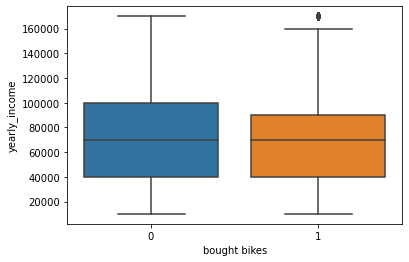

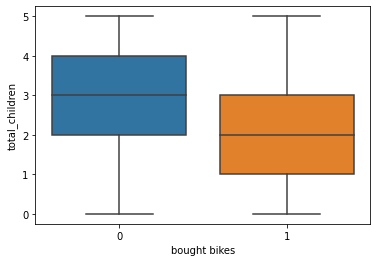

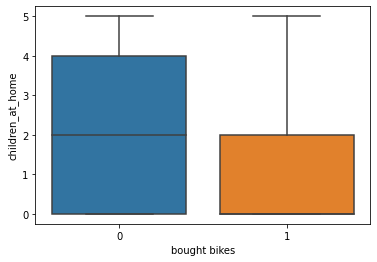

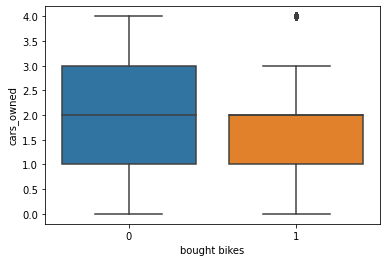

In [6]:
for col in df[['yearly_income', 'total_children', 'children_at_home', 'cars_owned']]:
    sns.boxplot('bikes', col, data=df)
    plt.xlabel('bought bikes')
    plt.ylabel(col)
    plt.show()

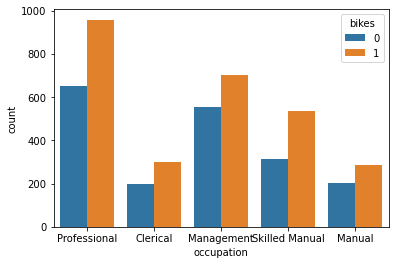

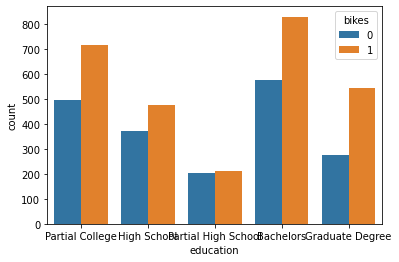

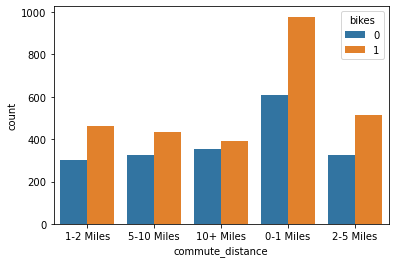

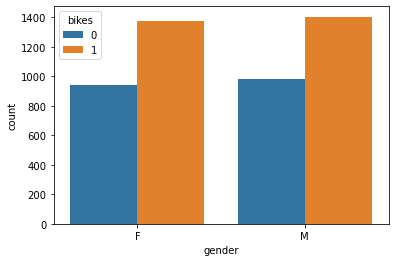

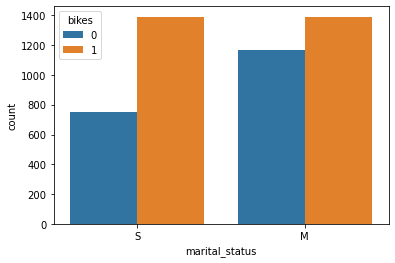

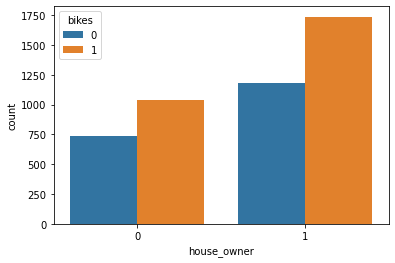

In [12]:
for col in ['occupation', 'education', 'commute_distance', 'gender', 'marital_status', 'house_owner']:
    ax = sns.countplot(x=col, hue='bikes', data=df)
    plt.show()

## 2.2. Mã hoá dữ liệu
Mã hoá các biến định tính
- Các biến dạng nominal:  gender, marital_status, occupation, education, commute_distance
- Các biến dạng binary: accessories, clothing, components, bike

#### Các cột accessories, clothing, components không tham gia mô hình dự đoán mua xe nên ta drop khỏi data

In [7]:
df_1=df.drop(['accessories','clothing','components'],1)
df_1

,gender,yearly_income,marital_status,total_children,children_at_home,house_owner,cars_owned,occupation,education,commute_distance,bikes
0,M,90000.0,M,4,1,0,3,Management,High School,5-10 Miles,1
1,F,130000.0,M,1,3,1,3,Management,Bachelors,2-5 Miles,1
2,F,20000.0,M,2,1,1,2,Clerical,Partial High School,1-2 Miles,1
3,M,30000.0,M,1,0,1,1,Manual,High School,1-2 Miles,1
4,M,60000.0,M,3,2,0,2,Professional,Bachelors,0-1 Miles,1
...,...,...,...,...,...,...,...,...,...,...,...
4688,F,30000.0,S,3,3,1,3,Clerical,Partial College,0-1 Miles,1
4689,F,20000.0,S,3,0,1,2,Clerical,Partial High School,1-2 Miles,0
4690,F,90000.0,M,0,0,0,1,Professional,Partial College,10+ Miles,0
4691,F,20000.0,M,0,0,0,1,Manual,Partial College,1-2 Miles,1


#### Đối với biến định tính *gender, marital_status, occupation, education, commute_distance*: sử dụng phương pháp One-hot Encoding

In [8]:
dummies = pd.get_dummies(df_1[['gender', 'marital_status','occupation','education','commute_distance']])
df_test = pd.concat([df_1.drop(columns=['gender', 'marital_status','occupation','education','commute_distance',]), dummies], axis=1)
df_test

,yearly_income,total_children,children_at_home,house_owner,cars_owned,bikes,gender_F,gender_M,marital_status_M,marital_status_S,...,education_Bachelors,education_Graduate Degree,education_High School,education_Partial College,education_Partial High School,commute_distance_0-1 Miles,commute_distance_1-2 Miles,commute_distance_10+ Miles,commute_distance_2-5 Miles,commute_distance_5-10 Miles
0,90000.0,4,1,0,3,1,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
1,130000.0,1,3,1,3,1,1,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2,20000.0,2,1,1,2,1,1,0,1,0,...,0,0,0,0,1,0,1,0,0,0
3,30000.0,1,0,1,1,1,0,1,1,0,...,0,0,1,0,0,0,1,0,0,0
4,60000.0,3,2,0,2,1,0,1,1,0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4688,30000.0,3,3,1,3,1,1,0,0,1,...,0,0,0,1,0,1,0,0,0,0
4689,20000.0,3,0,1,2,0,1,0,0,1,...,0,0,0,0,1,0,1,0,0,0
4690,90000.0,0,0,0,1,0,1,0,1,0,...,0,0,0,1,0,0,0,1,0,0
4691,20000.0,0,0,0,1,1,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0


### Biểu đồ phân phối

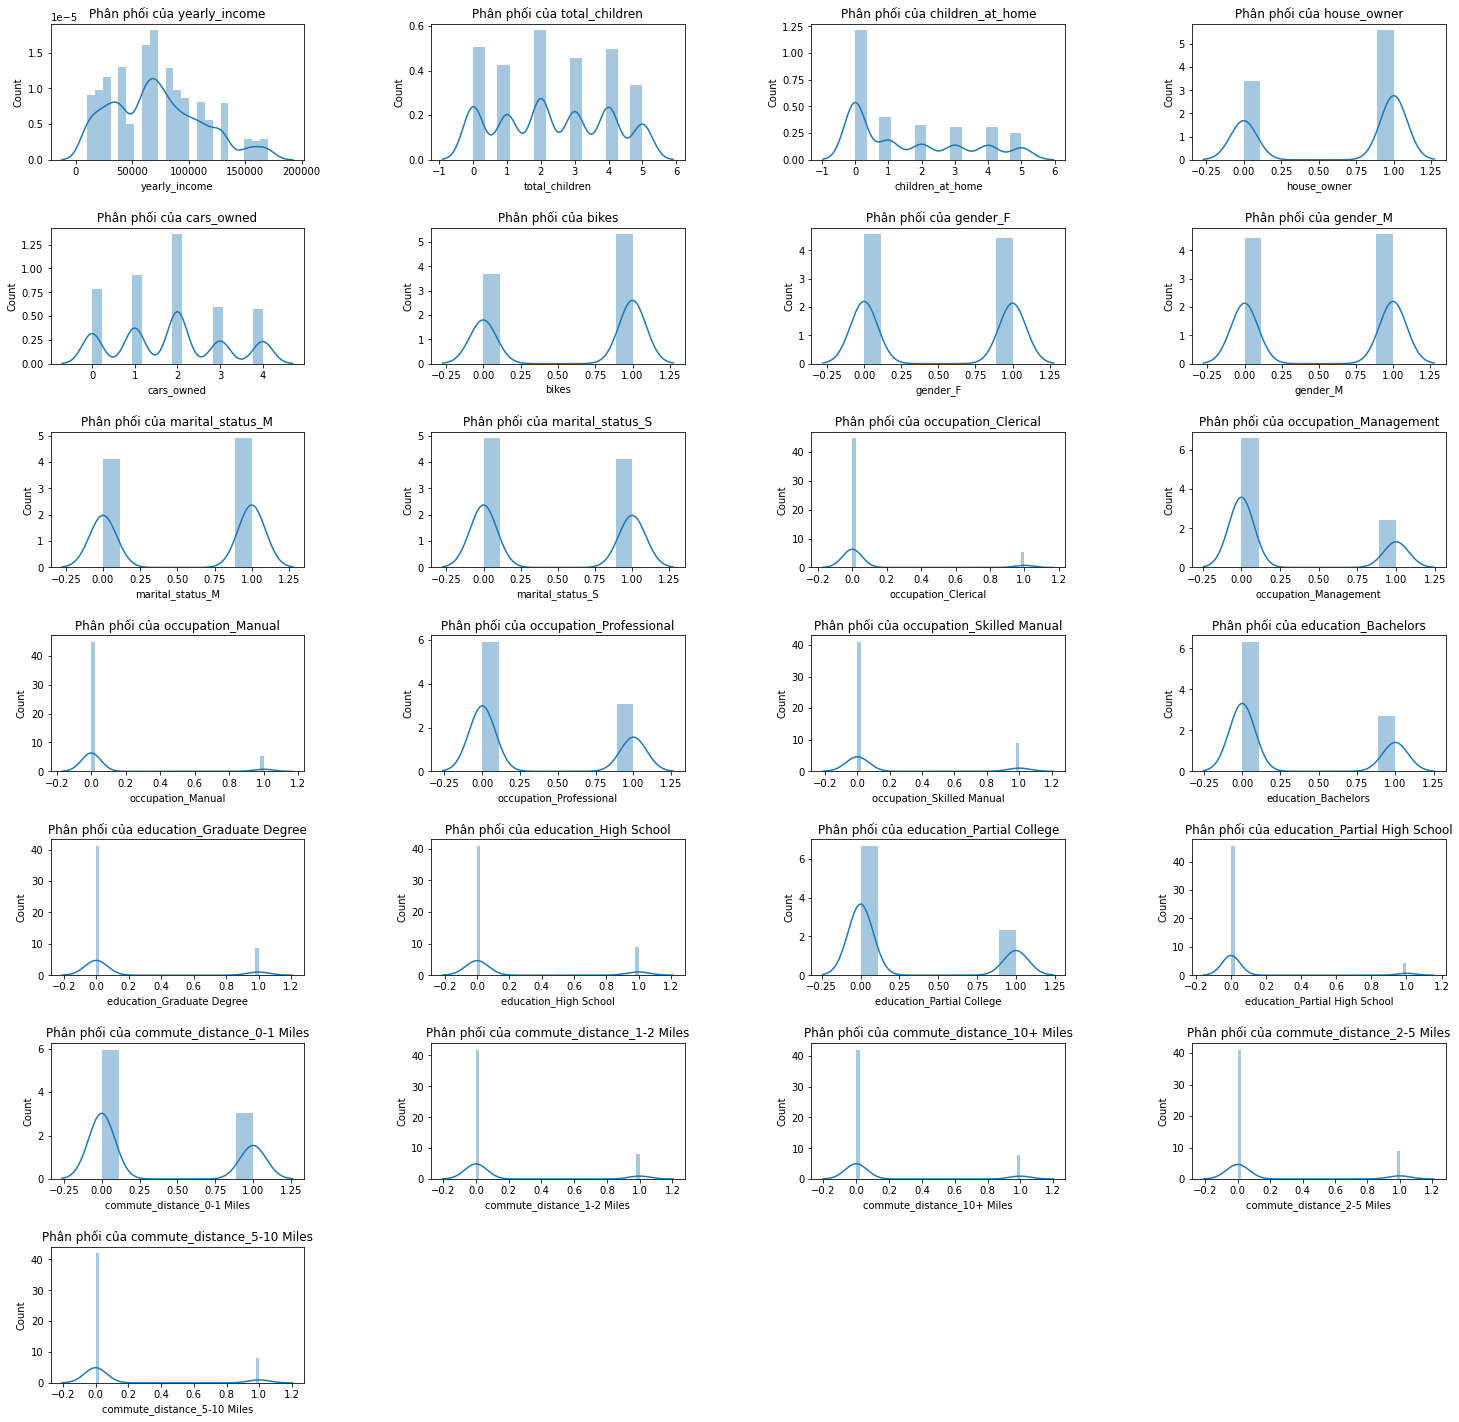

In [62]:
f, ax = plt.subplots(figsize=(25,25))
cols = len(df_test.columns)
for index, col in enumerate(df_test.columns):
  plt.subplot(cols/4 + 1, 4, index+1)
  sns.distplot(df_test[col].dropna())
  plt.title(f"Phân phối của {col}")
  plt.xlabel(col)
  plt.ylabel('Count')

plt.subplots_adjust(hspace=.5, wspace = .5)
plt.show()

### Biểu đồi Boxplot

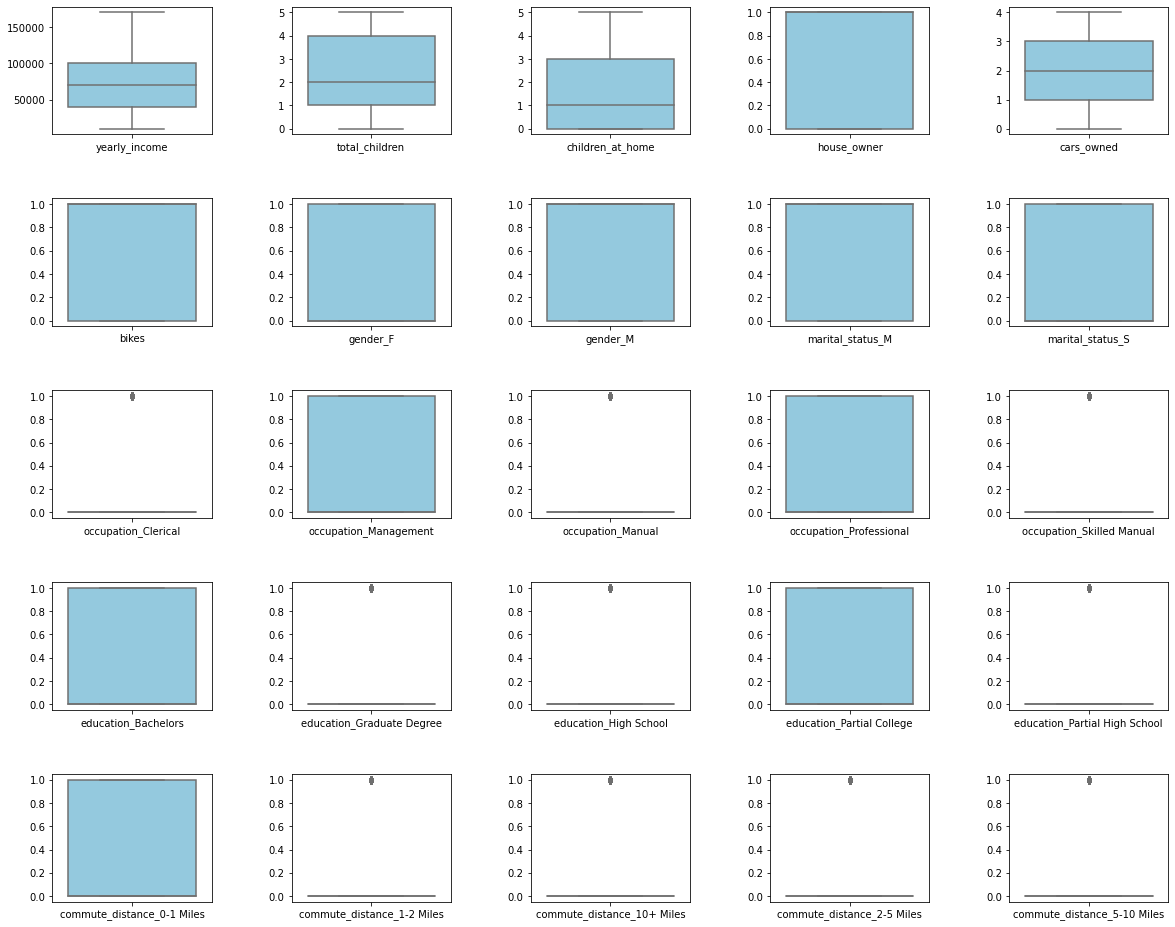

In [64]:
# Boxplots:
fig, axs = plt.subplots(figsize=(20, 20))
for index, col in enumerate(df_test.columns):
  plt.subplot(cols/5 + 1, 5, index+1)
  sns.boxplot(data=df_test, order=[col], color="skyblue", orient='v')
plt.subplots_adjust(hspace=.5, wspace = .5)
plt.show()

### Biểu đồ Heapmap

<AxesSubplot:>

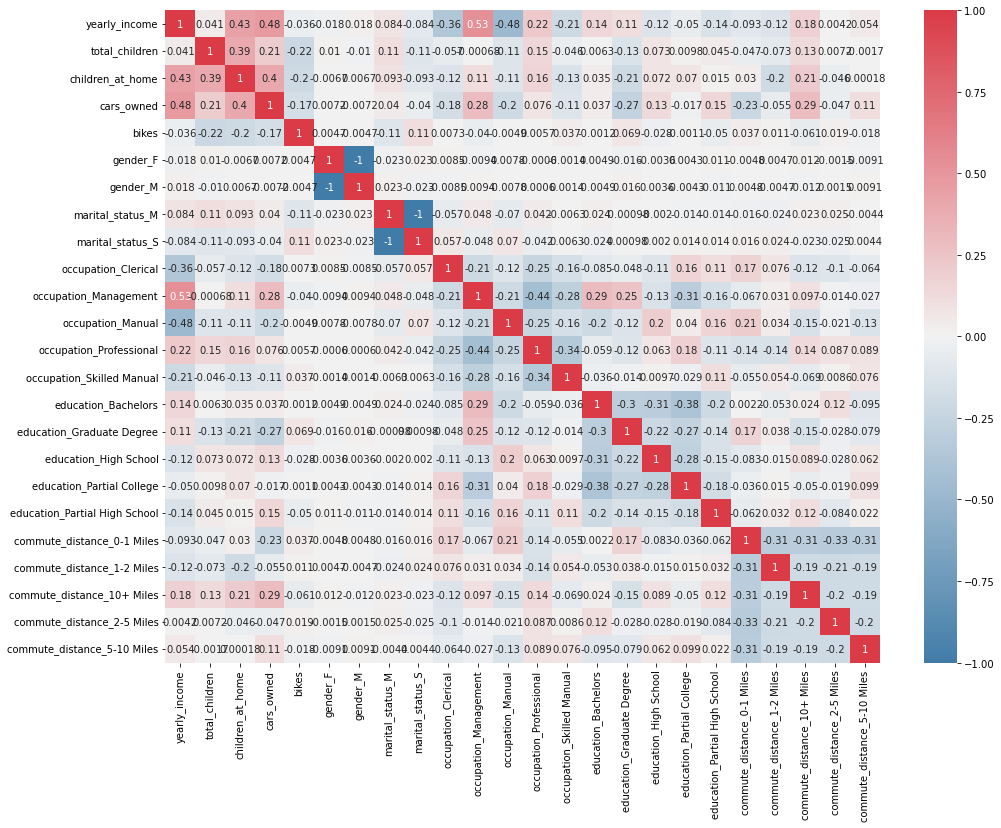

In [65]:
# Sự tương quan giữa các cột dữ liệu
## Ma trận tương quan:
corr = df_test.corr()
f, ax = plt.subplots(figsize=(16, 12))
## diverging_palette: khai báo màu tương ứng với mức độ tương quan
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
## heatmap: biểu đồ nhiệt biểu diễn sự tương quan giữa các cột trong tệp dữ liệu
sns.heatmap(corr, annot=True, cmap=cmap)

Nhận xét:
- 2 biến car_owner và yearly_income có độ tương quan thuận cao nhất (hệ số 0.48).
- Hai cặp biến gender_F và genden_M với martial_S và martial_M có độ tương quan nghịch thấp bởi vì hai biến này được mã hoá từ biến gender và martial (có hai loại giá trị) nên không mang ý nghĩa gì nhiều.
- Nhìn chung các biến khác không có sự tương quan đáng kể với nhau khi hệ số tương quan khá thấp


# 3. Lựa chọn mô hình và metric đánh giá
- 3.1. Lựa chọn mô hình
- 3.2. Lựa chọn metric

## 3.1. Lựa chọn mô hình
Ở đây em lựa chọn 3 mô hình để đánh giá:
- Logistic
- Decision Tree
- Random Forest

## 3.2. Lựa chọn metric.
Sử dụng 2 loại metric để đánh giá
- Confusion Matrix (Accuracy score, Precision score và Recall score)
- Phương pháp K-fold Cross-validation sẽ được sử dụng làm metric của bài toán này.

Đối với mô hình Random Forest, Out-of-bag score cũng sẽ được sử dụng.


# 4. Xây dựng mô hình, triển khai và đánh giá mô hình.

In [9]:
from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## 4.1. Xây dựng mô hình.
Đối với bài toán Phân lớp, nhóm chọn ra mô hình để xây dựng và đánh giá:

- Logistic
- Decision Tree
- Random Forest

### Chia tập train/test

In [10]:
y = df_test[['bikes']]
X = df_test.drop(columns=['bikes'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape,X_test.shape

((3754, 24), (939, 24))

### Xây dựng mô hình.

In [11]:
selected_models = []
selected_models.append(('Logistics', LogisticRegression()))
selected_models.append(('DecisionTree', DecisionTreeClassifier()))
selected_models.append(('Random Forest', RandomForestClassifier(n_jobs=-1, oob_score=True)))

In [13]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'f1-score' : make_scorer(f1_score)}

def build_and_analysis(df, models, k):
  res_df = pd.DataFrame(columns=[name for name, model in selected_models],
                        index=['Accuracy on training set', 'Accuracy', 'Precision', 'Recall', 'f1_score', 'OOB Score'])
                        
  print(y.value_counts())
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  for name, model in selected_models:
    model.fit(X_train, y_train)
    print('\n')
    print(name)

    #Độ chính xác
    print("Accuracy on Training set: ", model.score(X_train, y_train))
    print("Accuracy on Testing set: ", model.score(X_test, y_test))
    print('\n')

    #mô hình dự đoán
    y_pred = model.predict(X_test)
    #đánh giá mô hình
    print('confusion matrix')
    cfs_matrix = confusion_matrix(y_test, y_pred)
    cfs_df = pd.DataFrame(cfs_matrix, columns=['Predicted Positive', 'Predicted Negative'],
                          index=['Actual Positive', 'Actual Negative'])
    print(cfs_df.T)
    print('\n')
  
    print('classification report')
    print(classification_report(y_test, y_pred))
  
    # Đánh giá mô hình Random Forest với Out-of-bag score
    oob_score = None
    if name == 'Random Forest':
      oob_score = model.oob_score_
      print("Out-of-bag score: ", oob_score)
    print('=' * 60)

    # Lưu dữ liệu vào data frame kết quả
    res_df[name] = [model.score(X_train, y_train),
                    accuracy_score(y_test, y_pred),
                    precision_score(y_test, y_pred),
                    recall_score(y_test, y_pred),
                    f1_score(y_test, y_pred),
                    oob_score]
  return res_df

## 4.2. Triển khai mô hình.

### Phương pháp K-Fold Cross-validation

In [127]:
#Cross-validation
cv_mean = []
results = []
names = []
for name, model in selected_models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	cv_mean.append(cv_results.mean())
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

Logistics: 0.591519 (0.000883)
DecisionTree: 0.785216 (0.023921)
Random Forest: 0.767104 (0.017884)


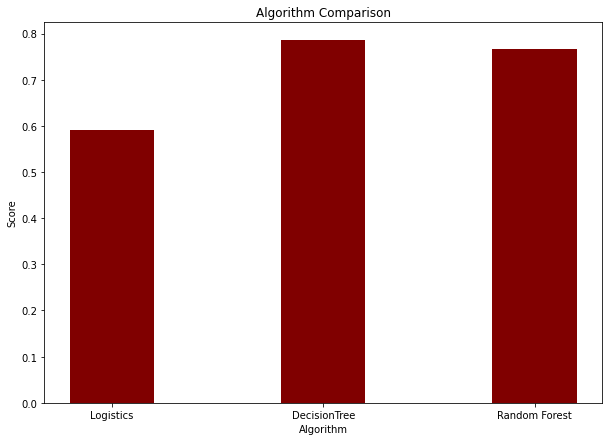

In [133]:
fig = plt.figure(figsize = (10, 7))
 
# creating the bar plot
plt.bar(names, cv_mean, color ='maroon',
        width = 0.4)
 
plt.xlabel("Algorithm")
plt.ylabel("Score")
plt.title("Algorithm Comparison")
plt.show()

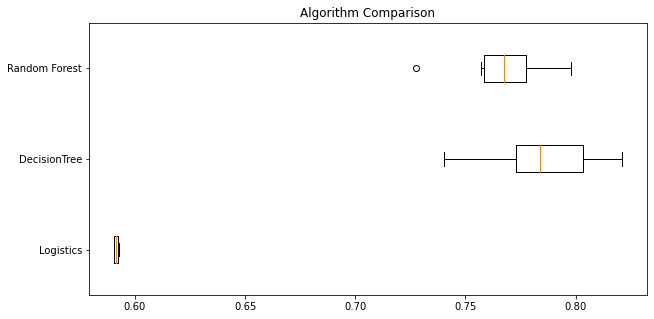

In [128]:
fig = plt.figure(1, figsize=(10,5))
plt.boxplot(results, labels=names, vert=False )
plt.title('Algorithm Comparison')
plt.show()

DecisionTree là mô hình có phân phối cao nhất

### Confusion Matrix

In [24]:
k=10
result=build_and_analysis(df_test, selected_models,k)

bikes
1        2776
0        1917
dtype: int64


Logistics
Accuracy on Training set:  0.5774733637747337
Accuracy on Testing set:  0.6242897727272727


confusion matrix
                    Actual Positive  Actual Negative
Predicted Positive                0                0
Predicted Negative              529              879


classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       529
           1       0.62      1.00      0.77       879

    accuracy                           0.62      1408
   macro avg       0.31      0.50      0.38      1408
weighted avg       0.39      0.62      0.48      1408



DecisionTree
Accuracy on Training set:  1.0
Accuracy on Testing set:  0.7762784090909091


confusion matrix
                    Actual Positive  Actual Negative
Predicted Positive              382              168
Predicted Negative              147              711


classification report
              precision    r

In [25]:
# Bảng thống kê đánh giá các mô hình đã chọn
result

,Logistics,DecisionTree,Random Forest
Accuracy on training set,0.577473,1.000000,1.000000
Accuracy,0.624290,0.776278,0.767756
Precision,0.624290,0.828671,0.804636
Recall,1.000000,0.808874,0.829352
f1_score,0.768693,0.818653,0.816807
OOB Score,NaN,NaN,0.740944


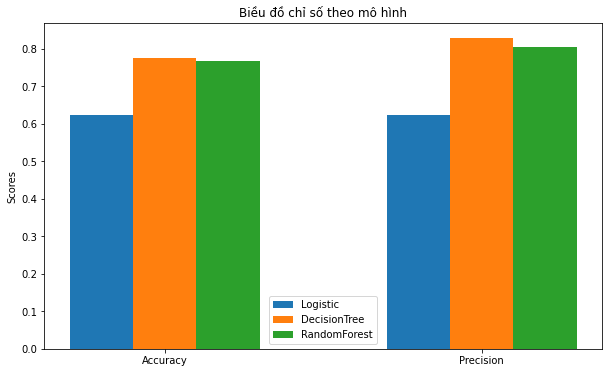

In [117]:
log=result['Logistics']['Accuracy':'Precision']
dec=result['DecisionTree']['Accuracy':'Precision']
ran=result['Random Forest']['Accuracy':'Precision']
labels = ['Accuracy', 'Precision']
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
f, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - 0.2, log, width, label='Logistic')
rects2 = ax.bar(x , dec, width, label='DecisionTree')
rects3 = ax.bar(x + 0.2, ran, width, label='RandomForest')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Biều đồ chỉ số theo mô hình')
ax.set_ylabel('Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend()
plt.show()

## 4.3. Đánh giá mô hình

- Mô hình Decision Tree và Random Forest đạt độ chính xác tuyệt đối với dữ liệu training.
- Đánh giá theo chỉ số tốt nhất trên tập test:
  - Accuracy: Mô hình Decision Tree
  - Precision: Mô hình Decision Tree
  - Recall: Mô hình Random Forest
  - f1_score: Mô hình Random Forest
- Ở phương pháp Cross-validation với k=10, Mô hình Decision Tree cũng có độ chính xác Accuracy cao nhất, các độ lệch chuẩn của mô hình không đáng kể và ổn định.
- Kết quả thu được mô hình Decision Tree và Random Forest có độ chính xác chênh lệch thấp
### Kết luận
Mô hình Decision Tree phù hợp với tập dữ liệu này và ngoài ra cũng có thể sử dụng Random Forest